In [1]:
!nvidia-smi

Wed May  4 05:04:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# DataLoader

In [2]:
from google.colab import files
files.upload() #upload kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
import time
time.sleep(5)
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d kedarsai/bird-species-classification-220-categories
!unzip -q /content/bird-species-classification-220-categories.zip
!rm -rf /content/bird-species-classification-220-categories.zip

Saving kaggle.json to kaggle.json
kaggle.json
 98% 1.04G/1.06G [00:06<00:00, 158MB/s]
100% 1.06G/1.06G [00:06<00:00, 164MB/s]


In [10]:
from glob import glob

cw = {}
c = len(glob('/content/Train/*/*'))

for i in range(200):

  cw[i] = 1000 * len(os.listdir(glob('/content/Train/*')[i])) / c


In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255.0,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   brightness_range = (0.1, 0.25),
                                   rotation_range = 20,
                                   vertical_flip = True,
                                   horizontal_flip = True,
                                   validation_split = 0.15)

# valid_datagen =  ImageDataGenerator(rescale = 1/255.0,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    brightness_range = (0.1, 0.25),
#                                    rotation_range = 20,
#                                    vertical_flip = True,
#                                    horizontal_flip = True,)
 
test_datagen =  ImageDataGenerator(rescale = 1/255.0,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   brightness_range = (0.1, 0.25),
                                   rotation_range = 20,
                                   vertical_flip = True,
                                   horizontal_flip = True,)
    
    
training_set = train_datagen.flow_from_directory('/content/Train/',
                                                 target_size = (224, 224),
                                                 batch_size = 128,
                                                 class_mode = 'categorical',
                                                 subset = 'training')

valid_set = train_datagen.flow_from_directory('/content/Train/',
                                            target_size = (224, 224),
                                            batch_size = 128,
                                            class_mode = 'categorical',
                                            subset = 'validation'
                                            )

test_set = test_datagen.flow_from_directory('/content/Test/',
                                            target_size = (224, 224),
                                            batch_size = 128,
                                            class_mode = 'categorical',)

Found 8045 images belonging to 200 classes.
Found 1369 images belonging to 200 classes.
Found 2374 images belonging to 200 classes.


# SQNet

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout
from keras.layers import Concatenate, Input, GlobalAveragePooling2D, Dense
from keras.models import Model


def SqueezeNet(input_shape, classes):


  def Fire(inputs, fs, fe):
    
    s1 = Conv2D(filters=fs, kernel_size=1, padding='same', use_bias=False, activation='relu')(inputs)
    s1 = BatchNormalization()(s1)
    e1 = Conv2D(filters=fe, kernel_size=1, padding='same', use_bias=False, activation='relu')(s1)
    e1 = BatchNormalization()(e1)
    e3 = Conv2D(filters=fe, kernel_size=3, padding='same', use_bias=False, activation='relu')(s1)
    e3 = BatchNormalization()(e3)

    output = Concatenate()([e1, e3])
  
    return output


  inputs = Input(input_shape)
  x1 = Conv2D(filters=96, kernel_size=7, strides=2, padding='same', use_bias=False, activation='relu')(inputs)
  x1= s1 = BatchNormalization()(x1)
  x1 = MaxPooling2D(pool_size=3, strides=2, padding='same')(x1)

  f2 = Fire(x1, 16, 64)
  f3 = Fire(f2, 16, 64)
  f4 = Fire(f3, 32, 128)
  x1 = MaxPooling2D(pool_size=3, strides=2, padding='same')(f4)

  f5 = Fire(x1, 32, 128)
  f6 = Fire(f5, 48, 192)
  f7 = Fire(f6, 48, 192)
  f8 = Fire(f7, 64, 256)
  x1 = MaxPooling2D(pool_size=3, strides=2, padding='same')(f8)

  f8 = Fire(x1, 64, 256)
  x1 = Conv2D(filters=classes, kernel_size=1)(f8)
  x1 = GlobalAveragePooling2D()(x1)

  if classes == 1:
    x1 = Activation('sigmoid')(x1)
  else:
    x1 = Activation('softmax')(x1)

  model = Model(inputs=inputs, outputs=x1)
  # model.summary()

  return model



In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
import tensorflow as tf

""" callbacks """
checkpoint_filepath = './SQNet_{epoch}.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    # monitor='val_iou_score',
    # mode='max',
    verbose = 1,
    period = 3,
    save_best_only=False)

csv_path = "./SQNet.csv"
callbacks = [
    model_checkpoint_callback,
    ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.5, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor="val_loss", patience=8)
]

In [6]:
model = SqueezeNet(input_shape = (224, 224, 3), classes=200)

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.Adam(0.005),
    metrics=['Precision', 'Recall', 'accuracy']
)

r1 = model.fit(
  training_set,
  validation_data=valid_set,
  batch_size=128,
  epochs=1000,
  steps_per_epoch=len(training_set),
  workers=-1,
  use_multiprocessing=True,
  validation_steps=len(valid_set),
  callbacks=callbacks,
  class_weight = cw,
)

model.save('./SqueezeNet_last.h5')

Epoch 1/1000
63/63 [==============================] - 213s 3s/step - loss: 19.2636 - precision: 0.7906 - recall: 0.0188 - accuracy: 0.2004 - val_loss: 7.2866 - val_precision: 0.0985 - val_recall: 0.0234 - val_accuracy: 0.0592 - lr: 0.0050
Epoch 2/1000
63/63 [==============================] - 188s 3s/step - loss: 18.6188 - precision: 0.7841 - recall: 0.0257 - accuracy: 0.2283 - val_loss: 5.5598 - val_precision: 0.2068 - val_recall: 0.0358 - val_accuracy: 0.0855 - lr: 0.0050
Epoch 3/1000
63/63 [==============================] - ETA: 0s - loss: 18.3429 - precision: 0.7737 - recall: 0.0344 - accuracy: 0.2440
Epoch 3: saving model to ./SQNet_3.h5
63/63 [==============================] - 193s 3s/step - loss: 18.3429 - precision: 0.7737 - recall: 0.0344 - accuracy: 0.2440 - val_loss: 5.7725 - val_precision: 0.1982 - val_recall: 0.0475 - val_accuracy: 0.1023 - lr: 0.0050
Epoch 4/1000
63/63 [==============================] - 183s 3s/step - loss: 17.9084 - precision: 0.8214 - recall: 0.0429 - ac

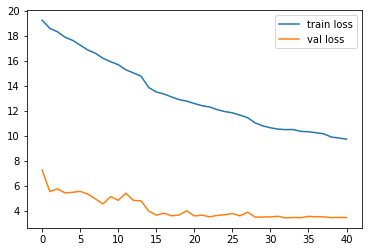

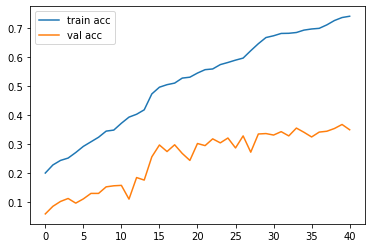

In [7]:
import matplotlib.pyplot as plt

# loss
plt.plot(r1.history['loss'], label='train loss')
plt.plot(r1.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r1.history['accuracy'], label='train acc')
plt.plot(r1.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


In [8]:
model.evaluate_generator(test_set, steps=64, workers=-1, use_multiprocessing=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[3.5432403087615967,
 0.7175043225288391,
 0.17438921332359314,
 0.35256949067115784]

# SQNetSE

In [11]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
from keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout
from keras.layers import Concatenate, Input, GlobalAveragePooling2D, Dense, Multiply
from keras.models import Model


def SqueezeNetSE(input_shape, classes):


  def SqueezeAndExcitation(inputs, ratio=8):
    
    b, h, w, c = inputs.shape
    
    x = GlobalAveragePooling2D()(inputs)
    x = Dense(c//ratio, activation='relu', use_bias=False)(x)
    x = Dense(c, activation='sigmoid', use_bias=False)(x)
    
    x = Multiply()([inputs, x])
    
    return x


  def Fire(inputs, fs, fe):
    
    s1 = Conv2D(filters=fs, kernel_size=1, padding='same', use_bias=False, activation='relu')(inputs)
    s1 = BatchNormalization()(s1)
    e1 = Conv2D(filters=fe, kernel_size=1, padding='same', use_bias=False, activation='relu')(s1)
    e1 = BatchNormalization()(e1)
    e3 = Conv2D(filters=fe, kernel_size=3, padding='same', use_bias=False, activation='relu')(s1)
    e3 = BatchNormalization()(e3)

    output = Concatenate()([e1, e3])
  
    return output


  inputs = Input(input_shape)
  x1 = Conv2D(filters=96, kernel_size=7, strides=2, padding='same', use_bias=False, activation='relu')(inputs)
  x1= s1 = BatchNormalization()(x1)
  x1 = MaxPooling2D(pool_size=3, strides=2, padding='same')(x1)

  f2 = Fire(x1, 16, 64)
  f3 = Fire(f2, 16, 64)
  f4 = Fire(f3, 32, 128)
  f4 = SqueezeAndExcitation(f4, ratio=8)
  x1 = MaxPooling2D(pool_size=3, strides=2, padding='same')(f4)

  f5 = Fire(x1, 32, 128)
  f6 = Fire(f5, 48, 192)
  f7 = Fire(f6, 48, 192)
  f8 = Fire(f7, 64, 256)
  f8 = SqueezeAndExcitation(f8, ratio=8)

  x1 = MaxPooling2D(pool_size=3, strides=2, padding='same')(f8)

  f8 = Fire(x1, 64, 256)
  x1 = Conv2D(filters=classes, kernel_size=1)(f8)
  x1 = GlobalAveragePooling2D()(x1)

  if classes == 1:
    x1 = Activation('sigmoid')(x1)
  else:
      x1 = Activation('softmax')(x1)

  model = Model(inputs=inputs, outputs=x1)
  # model.summary()

  return model


In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
import tensorflow as tf

""" callbacks """
checkpoint_filepath = './SQNetSE_{epoch}.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    # monitor='val_iou_score',
    # mode='max',
    verbose = 1,
    period = 3,
    save_best_only=False)

csv_path = "./SQNetSE.csv"
callbacks = [
    model_checkpoint_callback,
    ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.5, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor="val_loss", patience=7)
]

In [13]:
model = SqueezeNetSE(input_shape = (224, 224, 3), classes=200)

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    optimizer=tf.keras.optimizers.Adam(0.01),
    metrics=['accuracy']
)

r1 = model.fit(
  training_set,
  validation_data=valid_set,
  batch_size=128,
  epochs=1000,
  steps_per_epoch=len(training_set),
  workers=-1,
  use_multiprocessing=True,
  validation_steps=len(valid_set),
  callbacks=callbacks,
  class_weight = cw,

)

model.save('./SqueezeNetSE_last.h5')


Epoch 1/1000
63/63 [==============================] - 154s 2s/step - loss: 26.9999 - accuracy: 0.0107 - val_loss: 39.5979 - val_accuracy: 0.0051 - lr: 0.0100
Epoch 2/1000
63/63 [==============================] - 149s 2s/step - loss: 24.9602 - accuracy: 0.0247 - val_loss: 8.3026 - val_accuracy: 0.0051 - lr: 0.0100
Epoch 3/1000
63/63 [==============================] - ETA: 0s - loss: 23.7957 - accuracy: 0.0434
Epoch 3: saving model to ./SQNetSE_3.h5
63/63 [==============================] - 148s 2s/step - loss: 23.7957 - accuracy: 0.0434 - val_loss: 7.0816 - val_accuracy: 0.0110 - lr: 0.0100
Epoch 4/1000
63/63 [==============================] - 148s 2s/step - loss: 22.6620 - accuracy: 0.0697 - val_loss: 14.4930 - val_accuracy: 0.0073 - lr: 0.0100
Epoch 5/1000
63/63 [==============================] - 148s 2s/step - loss: 21.7999 - accuracy: 0.0920 - val_loss: 16.3616 - val_accuracy: 0.0110 - lr: 0.0100
Epoch 6/1000
63/63 [==============================] - ETA: 0s - loss: 20.9397 - accuracy

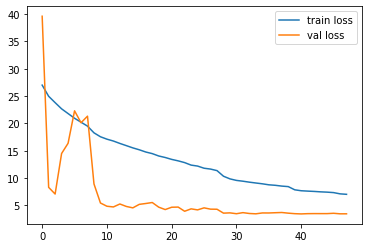

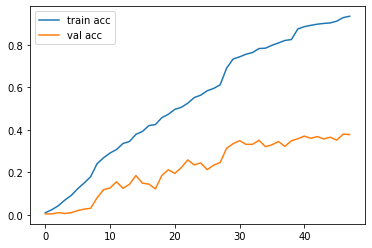

In [14]:
import matplotlib.pyplot as plt

# loss
plt.plot(r1.history['loss'], label='train loss')
plt.plot(r1.history['val_loss'], label='val loss')
plt.legend()
plt.show()+

# accuracies
plt.plot(r1.history['accuracy'], label='train acc')
plt.plot(r1.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()


In [15]:
model.evaluate_generator(test_set, steps=64, workers=-1, use_multiprocessing=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[3.5015084743499756, 0.3770008385181427]